# prepare_dlgn-p_rgc_data
This notebook loads the dataset of stimulus responses of dLGN-projecting RGCs, labelled retrogradely via 
dLGN-injection of a herpes simplex virus, and recorded using the Calcium-indicator GCaMP6f with a two-photon microscope.

### input
Multiple HDF5-files of pre-processed dLGN-p RGC fluorescence data.
One .mat file of prepared Baden2016 data, output by prepare_Baden2016_data.ipynb


### ouput
Single HDF5 file of pre-processed, resampled, normalized, deconvolved fluorescene data, including quality index  (QI) analysis of signal-to-noise ratio.

## Instructional note
While the pre-processed fluorescence data is stored on the lab-internal database currently not accessible from outside, this analysis file is still included to demonstrate the data preparation steps. The output HDF5 file has to be downloaded

# Setup

In [1]:
# Library/module setup

# System libs
import sys # system lib
import os # directory lib

# Data libs
import h5py # HDF5 lib
import numpy as np
import pandas as pd
from pandas import HDFStore
import scipy
import scipy.io
import copy
import time

# Misc libs
# for integration of plots into jupyter nb
%matplotlib inline

# Custom libs/mods
sys.path.append('../utils/') # Import path to utility function: norm.py, interp.py
import postProc as pop # Import PostProcessing module (functions: normalization, interpolation, QI etc.)
try:
    import pycircstat as circ # Philipp Berens' circular statistics lib (use pip install if not present)
except ImportError:
    !pip install pycircstat
try:
    import peakutils as pk # needed for Euler Lab classFuncs
except ImportError:
    !pip install peakutils

sys.path.append('../../../code/ret_preproc/dataProcessing/Python/postProcessing') # EulerLab retina postprocessing code
import classFuncs as cf # Euler Lab function set, import all

In [2]:
# Fig par
plt.style.use('ggplot')

In [17]:
# Parameter setup
p = {}
p.update({
         # IO pars
        'loadDirRaw': "../../data/2P/raw/gcamp6/", # load directory raw gcamp6f data
        'loadDirProc': "../../data/2P/proc/", # load directory processed data
        'saveDir': "../../data/2P/proc/", # save directory
        'saveFid': "dlgn-p_rgc_data",# "gcamp6Data_gcamp6fKern_40Hz.h5", # save as HDF5 file
        'savefileFmt': '.h5',
        'dtype': 'Pre', # work on preprocessed data (hdf5)
        
        # Choose what ogb-1 data to base analysis on
        'fidOgb1': 'BadenEtAl_RGCs_2016_ogb1', # processed OGB-1 file (OGB1 groups)
        'fileFmtOgb1': '.mat', 
        'groupVClu': 'clu', # OPTIONS: 'group', 'clu'
        'deconvMethodO1': 'ogb1Kern', # OPTIONS: 'ogb1Kern', 'foopsi'
        'fps': '7.8Hz',
        
        # Set stimuli of interest & var names for dataframe accordingly
        'stim': ["chirp", "bar"], # stimulus name
        'stimFile': ["Chirps.h5", "DS.h5"], # stimulus file name (NOTE: put same order as 'stim'!)
        
        # Resampling pars
        'chirpDurGcamp6': 32.782, #  mean chirp duration in gcamp6f data
        
        # Normalization pars
        'normMode': 'meanMax', # OPTIONS: 'meanMax', 'medMax', 'r', 'z' (more options, see postProc.py)
        
        # Deconvolution pars
        'deconvMethod': 'gcamp6fKern', # OPTIONS: 'gcamp6fKern', 'foopsi'
        
        # Quality index (QI) pars
        'chirpMinQi': 0.45, # Baden2016: 0.45
        'barMinQi': 0.6, # Baden2016: 0.6
    })


# Build file names
p['saveFid'] = p['saveFid']+"_"+p['deconvMethod']+"_"+p['fps']+p['savefileFmt']
p['fidOgb1'] = p['fidOgb1']+"_"+p['groupVClu']+"_"+p['deconvMethodO1']+"_"+p['fps']+p['fileFmtOgb1']
p

{'loadDirRaw': '../../data/2P/raw/gcamp6/',
 'loadDirProc': '../../data/2P/proc/',
 'saveDir': '../../data/2P/proc/',
 'saveFid': 'dlgn-p_rgc_data_gcamp6fKern_7.8Hz.h5',
 'savefileFmt': '.h5',
 'dtype': 'Pre',
 'fidOgb1': 'BadenEtAl_RGCs_2016_ogb1_clu_ogb1Kern_7.8Hz.mat',
 'fileFmtOgb1': '.mat',
 'groupVClu': 'clu',
 'deconvMethodO1': 'ogb1Kern',
 'fps': '7.8Hz',
 'stim': ['chirp', 'bar'],
 'stimFile': ['Chirps.h5', 'DS.h5'],
 'chirpDurGcamp6': 32.782,
 'normMode': 'meanMax',
 'deconvMethod': 'gcamp6fKern',
 'chirpMinQi': 0.45,
 'barMinQi': 0.6}

# Load processed ogb1-data
here, only used for time alignment of gcamp6gf

In [6]:
ogb1 = scipy.io.loadmat(p['loadDirProc']+p['fidOgb1'])
scipy.io.whosmat(p['loadDirProc']+p['fidOgb1'])

[('chirpMean', (249, 49), 'double'),
 ('barDeconvMean', (32, 49), 'double'),
 ('barMeanDeconv', (32, 49), 'double'),
 ('barTime', (1, 32), 'double'),
 ('somaSizeIdx', (49, 1), 'int64'),
 ('barN', (1, 49), 'int64'),
 ('chirpDeconvSd', (249, 49), 'double'),
 ('barMed', (32, 49), 'double'),
 ('barDeconvSd', (32, 49), 'double'),
 ('dsIdx', (49, 1), 'int64'),
 ('chirpMeanDeconv', (249, 49), 'double'),
 ('chirpN', (1, 49), 'int64'),
 ('chirpDeconvMean', (249, 49), 'double'),
 ('chirpTime', (1, 249), 'double'),
 ('barSd', (32, 49), 'double'),
 ('chirpMed', (249, 49), 'double'),
 ('barMean', (32, 49), 'double'),
 ('chirpSd', (249, 49), 'double')]

In [7]:
## Update OGB1 time info
# (.mat files seem to require storage as 2D)
for iStim in p['stim']:
    ogb1[iStim+'Time'] = ogb1[iStim+'Time'][0,:]
    ogb1[iStim+'Dur'] = ogb1[iStim+'Time'][-1] - ogb1[iStim+'Time'][0] # Get stim duration
    ogb1[iStim+'SRate'] = len(ogb1[iStim+'Time']) / ogb1[iStim+'Dur']
    print(ogb1[iStim+'Dur'])

31.82049156626506
4.0


# Function: direction selectivity (DS)

In [ ]:
def ds_ana(traces):
    """
    Summary analysis function for multiple direction selectivity (DS) functions.
    """
    
    ## Get DS-stimulus info
    # Direction vector (in degrees)
    _, _, dirs, _ = cf.create_ds_stim()
        
    # Convert dirs to mathematical convention: 0 deg = bar moves left to right
    # As 0 deg currently = top to bottom, etc., this encoding is a shift from convention by 270 deg
    dirs = [((x + 270) % 360) for x in dirs]

    # Convert directions from deg2rad
    dirsRad = np.deg2rad(dirs)

    # Trial idx for same dirs
    dirIdx = [[0,8,16],[1,9,17],[2,10,18],[3,11,19],[4,12,20],[5,13,21],[6,14,22],[7,15,23]]

    ## Analyse DS
    # Get average response of each ROI per direction
    dsMatrix = np.zeros([traces.shape[0], len(dirIdx), traces.shape[2]])
    for i in range(traces.shape[2]):
        
        # Get condition average traces
        dsMatrix[:,:,i] = cf.avg_matrix(traces[:,:,i], grouping=dirIdx)

        # Order responses by direction condition
        dsMatrix[:,:,i] = dsMatrix[:, np.argsort(dirsRad), i]

        # Normalize avg matrix
        dsMatrix[:,:,i] = (dsMatrix[:,:,i] - np.median(dsMatrix[0:8,:,i], axis=0))
        dsMatrix[:,:,i] = dsMatrix[:,:,i] / np.max(np.abs(np.median(dsMatrix[:,:,i], axis=1)))

    # Sort trial traces by condition    
    tracesSort = traces[:,dirIdx,:] # (40, 8, 3, 23) (time, condition, trial, roi)
    tracesSort = tracesSort[:,np.argsort(dirsRad),:,:]

    # Sort direction condition
    dirsRad = np.sort(dirsRad)

    # Direction selectivity analysis of each ROI
    dsVector  = np.zeros([len(dirIdx), dsMatrix.shape[2]])
    dsIdx = np.zeros([dsMatrix.shape[2]])
    pVal = np.zeros([dsMatrix.shape[2]])
    qVal = np.zeros([dsMatrix.shape[2]])

    for i in range(dsMatrix.shape[2]):    
        # Get DS vector using SVD
        [dsVector[:,i], tc, _] = cf.direction_selectivity(matrix=dsMatrix[:,:,i])

        # Get projection of time-component onto traces using SVD (for tuning significance test)
        tcProj = np.inner(tracesSort[:,:,:,i].T, tc)

        # Get DS index
        dsIdx[i] = circ.resultant_vector_length(alpha=dirsRad, w=dsVector[:,i], d=np.diff(np.sort(dirsRad)[0:2]))

        # Test DS-tuning significance via permutation test
        [pVal[i], qVal[i], _] = cf.testTuning(dirs=dirsRad, counts=tcProj, per=1) # note: per=1: 1st fourier comp
        
    return dsMatrix, dsVector, dsIdx, pVal, qVal

# Function: getGcamp6fData

In [ ]:
def getGcamp6fData(p, iStim, ogb1):
    """
    Summary function calling multiple analysis functions on a recording field file (hdf5).
    INPUT:
    ------
    p : dict
        parameters
    iStim : scalar
        current stim
    ogb1 : dict
        ogb1 data. Used only for time-alignment of gcamp6f data
    OUTPUT:
    ------
    dataTmp : pandas dataframe
        gcamp6f data for current field
    """
    ## Load data
    # Gets single input file of a field for a stimulus
    with h5py.File(p['loadDirRaw']+p['date']+'/'+p['field']+'/'+p['dtype']+'/'+p['stimFile'][iStim], 'r') as f:
        data = {key:f[key][:] for key in list(f.keys())} # dictionary comprehension

    # Get snippets 
    # Snippets = traces time series for whole field [time x trial x ROI]
    snippets = data['Snippets0']

    # Get snippets times
    snippetsTimes = data['SnippetsTimes0']

    # Remove Nans
    snippets = snippets[:, :, np.any(np.any(~np.isnan(snippets), axis=1), axis=0)]
    snippetsTimes = snippetsTimes[:, :, np.any(np.any(~np.isnan(snippetsTimes), axis=1), axis=0)]

    # If Chirp-stim
    if p['stimFile'][iStim] == 'Chirps.h5':
        nSamples = snippets.shape[0]
        ## Clip snippet duration to equal that of OGB1-Data

        # Get median duration of snippets times (as it varies slightly from field to field, and ROI to ROI)
        stimDur = np.median(np.max(snippetsTimes, axis=0) - snippetsTimes[0,:,:])
        # If you find nans, then set stimDur to median gcamp6Chirp-duration
        if np.isnan(stimDur):
            warnings.warn('NaNs in %s-%s-%s' % (p['date'], p['field'], p['stimFile'][iStim]))
            stimDur = p['chirpDurGcamp6'] # hacky! mend tomorrow

        # Calculate sampling rate
        sRate = nSamples / stimDur

        # Find start and end point to clip (in samples)
        start = int(np.floor(ogb1['chirpTime'][0] * sRate))
        stop = int(np.floor(ogb1['chirpTime'][-1] * sRate))

        # Clip gcamp6 snippets and snippetTimes to duration of ogb1
        snippets = snippets[start:stop]
        snippetsTimes = snippetsTimes[start:stop]

    ## Resample so that nSamplesGcamp6 = nSamplesOgb1
    ogb1SRate = ogb1[p['stim'][iStim]+'SRate'] # 7.825
    ogb1StimDur = ogb1[p['stim'][iStim]+'Dur']
    snippets = pop.interpNewSRate(snippets, ogb1SRate, ogb1StimDur)
    
    ## Normalize and get snippet means/med & sds
    snippets = pop.normalize(snippets, mode='meanMax') # normalize for mean (mode: cf. methods Baden2016)
    snippetsMean = np.mean(snippets, axis=1)
    snippetsSd = np.std(snippets, axis=1)

    snippets = pop.normalize(snippets, mode='medMax') # normalize for median (mode: cf. methods Baden2016)    
    snippetsMed = np.median(snippets, axis=1)

    ## Deconvolution 
    # Get mean deconvolved trace per ROI
    deconvTraces = np.zeros((snippets.shape[0], snippets.shape[1], snippets.shape[2])) 
    deconvMean = np.zeros((snippets.shape[0], snippets.shape[2]))
    deconvSd = np.zeros((snippets.shape[0], snippets.shape[2]))
    for iRoi in range(snippets.shape[2]):
        d, traceSm = pop.deconv(snippets[:,:,iRoi], fps=ogb1SRate, method=p['deconvMethod'], smooth=True, norm=True)
        # Get normalized trace
        deconvTraces[:,:,iRoi] = pop.normalize(d, mode='meanR') # (mean) range norm due to non-negativity of firing rates
        # Get mean and sd
        deconvMean[:,iRoi] = np.mean(deconvTraces[:,:,iRoi], axis=1)
        deconvSd[:,iRoi] = np.std(deconvTraces[:,:,iRoi], axis=1)
        
    ## Get quality indices (QI)
    # Chirp
    if p['stimFile'][iStim] == 'Chirps.h5':
        qis = pop.qi(snippets)
    # Bar - requires variation: get QI for each direction and take max for each cell
    elif p['stimFile'][iStim] == 'DS.h5':
        dirIdx =[[0,8,16],[1,9,17],[2,10,18],[3,11,19],[4,12,20],[5,13,21],[6,14,22],[7,15,23]] # Vector of bar directions
        qis = np.zeros((len(dirIdx), snippets.shape[2])) # [nDirections, nRois]
        # Loop through directions
        for i in range(len(dirIdx)):
            qis[i] = pop.qi(snippets[:, dirIdx[i], :])
        # Take max of QIs as QI for each ROI
        qis = np.max(qis, axis=0)

    ## For DS/bar-stimulus, do direction selectivity (DS) analysis
    if p['stimFile'][iStim] == 'DS.h5':
            dsMatrix, dsVector, dsIdx, dsPVal, _ = ds_ana(snippets)

    ## Get cell soma areas
    # Get ROI mask
    rois = data['ROIs']
    # Get areas
    areas, _ = cf.roi_area(rois)   

    ## Insert data into temp df
    # NOTE: for traces, consider sth like pd.Series(list(np.swapaxes(dsMatrix.T, 1, 2))) # swap ax to keep [time, trial] order
    dataTmp = pd.DataFrame({
            "date": iDate,
            "field": iField,
            "roi": pd.Series(range(1, snippetsMean.shape[1]+1), index=list(range(snippetsMean.shape[1]))),
            # Insert stimulus-specific data, w flexible var names according to stimulus
            p['stim'][iStim]+"Traces": pd.Series(list(snippets.T)), # add 3D array to pd df 
            p['stim'][iStim]+"Mean": pd.Series(list(snippetsMean.T)),
            p['stim'][iStim]+"Med": pd.Series(list(snippetsMed.T)),
            p['stim'][iStim]+"Sd": pd.Series(list(snippetsSd.T)),
            p['stim'][iStim]+"DeconvTraces": pd.Series(list(deconvTraces.T)),
            p['stim'][iStim]+"DeconvMean": pd.Series(list(deconvMean.T)),
            p['stim'][iStim]+"DeconvSd": pd.Series(list(deconvSd.T)),
            p['stim'][iStim]+"Qi": qis, # QI named according to stimulus
            "somaArea": areas, # Soma areas
              })
    # For bar-stim, add DS-info to dataTmp
    if p['stimFile'][iStim] == 'DS.h5':
        # Insert DS info into tmpData
        dataTmp["barCondAvgTraces"] = pd.Series(list(dsMatrix.T)) # swap ax to keep [time, trial] order
        dataTmp["dsVector"] = pd.Series(list(dsVector.T))
        dataTmp["dsi"] = pd.Series(list(dsIdx))
        dataTmp["dsPVal"] = pd.Series(list(dsPVal))

    # Give some summary info
    print("\tgetGcamp6fData(): Getting data for %d rois." % snippets.shape[2]) # [time x trial x ROI]

    return dataTmp

# Data Processing

### Method:
Data storage: date > field > pre > one hdf5 per stimulus, containing 1+ rois.
Data retrieval: call function getGcamp6Data(p) for all fields and collect data into one dataframe

In [ ]:
# Time cell execution
start = time.time()

# get current working dir
print(os.getcwd())

# Initialize data frame for each stimulus
chirpData = pd.DataFrame(columns=['date', 'field', 'roi'])
barData = pd.DataFrame(columns=['date', 'field', 'roi'])

# Get all recording dates (list of data folders (excl hidden files))
dates = [date for date in os.listdir(p['loadDirRaw']) if not date.startswith('.')]
print('dates:', dates)
for iDate in dates:
    p.update({'date': iDate}) # set date dir
    print('Date:', iDate)
    # Get list of recorded fields (excl hidden files))
    fields = [field for field in os.listdir(p['loadDirRaw']+p['date']) if not field.startswith('.')]
    print('Fields:', fields)
    for iField in fields:
        p.update({
                'field': iField, # set field dir
                'dtype': 'Pre', # use preprocessed data
                }) 
        print(' Field', iField)
#         print(p['loadDirRaw']+p['date']+'/'+p['field']+'/'+p['dtype']+'/')

        # Loop through all stimuli of interest
        for iStim, stim in enumerate(p['stimFile']):
            print('  Stimulus:', stim)
            
            if p['stimFile'][iStim] in os.listdir(p['loadDirRaw']+p['date']+'/'+p['field']+'/'+p['dtype']+'/'):
                
                # Get gcamp6 data
                dataTmp = getGcamp6fData(p, iStim, ogb1)
                
                # Append data to appropriate stimulus data
                if p['stimFile'][iStim] == 'Chirps.h5':
                    chirpData = chirpData.append(dataTmp, ignore_index=True)
                    
                elif p['stimFile'][iStim] == 'DS.h5':
                    barData = barData.append(dataTmp, ignore_index=True)                    

            else:
                continue

print('DONE.')
dur = (time.time() - start)
print('Duration: %.2f sec = %.2f min' %(dur, dur/60))

In [ ]:
print('DONE.')

## Find and exclude cell number mismatches between stimuli

In [ ]:
data = pd.merge(chirpData, barData, how='inner')

## Apply QI criteria to filter out cells

NOTE: this should also take care of any traces w NaNs, which will produce a qi = 0 (according to qiFun)

In [ ]:
nCellsOrig = data.index.size # original pre-criterion number of cells
data = data[(data.chirpQi > p['chirpMinQi']) | (data.barQi > p['barMinQi'])]

# Print summary
print('QI-criterion: QI_chirp: %.2f, QI_bar:%.2f' % (p['chirpMinQi'], p['barMinQi']))
print('QI-criterion: keeping %d/%d cells -> %d cells thrown out.' %
      (data.index.size, nCellsOrig, (nCellsOrig - data.index.size)))

# Reset index to reflect new number of cells
data = data.reset_index(drop=True)

# Save data

In [ ]:
# Check save directory
print('Saving data to:', p['saveDir']+p['saveFid'])

In [ ]:
store = HDFStore(p['saveDir']+p['saveFid']) # create file
store['data'] = data # save data into file
store.close() # close file

# Supplemental code

## Data exploration

date: 20160223
 nFields: 15
 nCells: 121
 nCellsPerField: 8.1
  f01: n=3
  f03: n=23
  f04: n=13
  f05: n=11
  f06: n=20
  f07: n=20
  f08: n=9
  f09: n=4
  f10: n=2
  f11: n=3
  f12: n=4
  f13: n=1
  f14: n=1
  f15: n=3
  f16: n=4
date: 20160224
 nFields: 13
 nCells: 64
 nCellsPerField: 4.9
  f01: n=1
  f02: n=6
  f03: n=7
  f04: n=4
  f05: n=6
  f06: n=3
  f07: n=13
  f08: n=3
  f09: n=5
  f10: n=8
  f11: n=6
  f12: n=1
  f13: n=1
date: 20160420
 nFields: 16
 nCells: 51
 nCellsPerField: 3.2
  f01: n=3
  f02: n=5
  f03: n=5
  f04: n=5
  f05: n=3
  f06: n=5
  f07: n=4
  f08: n=4
  f09: n=3
  f10: n=2
  f11: n=1
  f12: n=2
  f13: n=2
  f14: n=3
  f15: n=3
  f16: n=1
date: 20160421
 nFields: 25
 nCells: 345
 nCellsPerField: 13.8
  f01: n=2
  f02: n=4
  f03: n=16
  f04: n=12
  f05: n=13
  f06: n=15
  f07: n=18
  f08: n=16
  f09: n=14
  f10: n=10
  f11: n=23
  f12: n=15
  f13: n=10
  f14: n=11
  f15: n=18
  f16: n=15
  f17: n=14
  f18: n=19
  f19: n=25
  f20: n=12
  f21: n=6
  f22: n=16
  

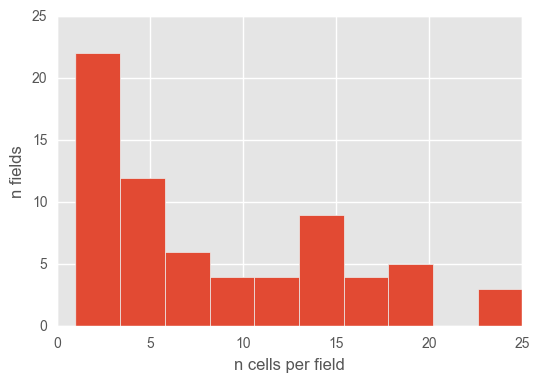

In [38]:
nFieldsTot = 0 # Total nFields counter

cells_per_field_all = []

for i in np.unique(gcamp6.date):
    print('date:', i)
    
    nFields = len(np.unique(gcamp6.field[gcamp6.date == i]))
    print(' nFields:', nFields)
    nFieldsTot += nFields
    
    nCells = len(gcamp6.roi[(gcamp6.date == i)])
    print(' nCells:', nCells)    
    
    nCellsPerField = nCells/nFields
    print(' nCellsPerField: %.1f' % np.round(nCellsPerField,1))
    
    for x in np.unique(gcamp6.field[gcamp6.date == i]):
        cellsInField = len(gcamp6.roi[(gcamp6.date == i) & (gcamp6.field == x)])
        print('  f%s: n=%i' % (x, cellsInField))        
        cells_per_field_all.append(cellsInField)
    
print('\nTotal nFields:', nFieldsTot)
print('Total nCells:', len(gcamp6))
# print('Mean+SD nCellsPerField:', np.round(len(gcamp6)/nFieldsTot, 1))
print('Mean+SD nCellsPerField: %.1f±%.1f' % \
      (np.round(np.mean(cells_per_field_all),1), np.round(np.std(cells_per_field_all),1)))
print('Median nCellsPerField: %.1f' % \
      (np.round(np.median(cells_per_field_all),1)))
print('range nCellsPerField: %i-%i' % \
      (np.min(cells_per_field_all), np.max(cells_per_field_all)))

# Plot histogram of cells per fields by n fields
plt.hist(cells_per_field_all)
plt.xlabel('n cells per field')
plt.ylabel('n fields')